This Notebook contains the same setup as PaSST_setup2 with a new pretrained architecture choice: PaSST pre-trained on AudioSet (with KD) Patch 16 stride 10 structured patchout mAP=486

In [ ]:
# Cell 1: Setup and Imports
# Install required packages
!pip install hear21passt
!pip install torch torchaudio
!pip install pytorch-lightning
!pip install wandb

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import pandas as pd
import torch
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from hear21passt.base import get_basic_model, get_model_passt

# Define paths
base_path = "/content/drive/My Drive/LUMT_Thesis_Resources"
metadata_path = os.path.join(base_path, "groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified.csv")

# Print metadata columns to verify
metadata = pd.read_csv(metadata_path)
print("Metadata columns:", metadata.columns.tolist())
print("\nSample of metadata:")
print(metadata[['audio_filename', 'file_path', 'style_class', 'audio_samples']].head())

Mounted at /content/drive
Metadata columns: ['id', 'split', 'bpm', 'drummer', 'time_signature', 'type', 'style_primary', 'style_secondary', 'midi_size', 'audio_samples', 'audio_filename', 'file_path', 'style_class']

Sample of metadata:
                 audio_filename  \
0  drummer1_session1_51_003.wav   
1  drummer7_session2_45_002.wav   
2   drummer6_session3_7_000.wav   
3  drummer7_session2_64_040.wav   
4   drummer6_session3_2_017.wav   

                                           file_path   style_class  \
0  /content/drive/My Drive/LUMT_Thesis_Resources/...  rock_shuffle   
1  /content/drive/My Drive/LUMT_Thesis_Resources/...          rock   
2  /content/drive/My Drive/LUMT_Thesis_Resources/...          rock   
3  /content/drive/My Drive/LUMT_Thesis_Resources/...          rock   
4  /content/drive/My Drive/LUMT_Thesis_Resources/...          rock   

   audio_samples  
0          61440  
1          56889  
2          87272  
3          52965  
4          76800  


#resampling test (do not need to rerun)

but you can for sanity check

In [ ]:
# Cell 2: Test Resampling on Single File
def test_resampling(audio_path, target_sr=32000):
    # Load audio
    waveform, sample_rate = torchaudio.load(audio_path)
    print(f"Original waveform shape: {waveform.shape}")
    print(f"Original sample rate: {sample_rate}")

    # Convert to mono if needed
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
        print("Converted to mono")

    # Resample
    resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
    resampled = resampler(waveform)

    print(f"Resampled waveform shape: {resampled.shape}")
    print(f"New sample rate: {target_sr}")

    # Calculate duration
    duration = resampled.shape[1] / target_sr
    print(f"Duration: {duration:.2f} seconds")

    return resampled

# Test on a single file
test_file = metadata.iloc[0]['file_path']  # Get first file path
test_audio_path = os.path.join(base_path, test_file)
resampled_audio = test_resampling(test_audio_path)

Original waveform shape: torch.Size([1, 61440])
Original sample rate: 16000
Resampled waveform shape: torch.Size([1, 122880])
New sample rate: 32000
Duration: 3.84 seconds


#Verify Directories (do not need to rerun)

sanity check if desired

In [ ]:
# Cell 2.5: Verify Directories and Files
import os
import pandas as pd

# Define the base path where audio files are stored
base_path = "/content/drive/My Drive/LUMT_Thesis_Resources"

# Define paths for train, test, and validation audio folders
train_audio_path = os.path.join(base_path, "groove_2bar_audio_train/")
test_audio_path = os.path.join(base_path, "groove_2bar_audio_test/")
val_audio_path = os.path.join(base_path, "groove_2bar_audio_validation/")

# Define metadata path
metadata_path = os.path.join(base_path, "groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv")

# Verify paths exist
print("Checking directories and files:")
print(f"Base path exists: {os.path.exists(base_path)}")
print(f"Metadata file exists: {os.path.exists(metadata_path)}")
print(f"Train audio directory exists: {os.path.exists(train_audio_path)}")
print(f"Test audio directory exists: {os.path.exists(test_audio_path)}")
print(f"Validation audio directory exists: {os.path.exists(val_audio_path)}")

# Load metadata and check file paths
metadata = pd.read_csv(metadata_path)
print("\nChecking sample file paths:")
for split, audio_path in [('train', train_audio_path),
                         ('test', test_audio_path),
                         ('validation', val_audio_path)]:
    split_files = metadata[metadata['split_rev'] == split]['audio_filename'].head(3)
    print(f"\nSample files for {split} split:")
    for filename in split_files:
        full_path = os.path.join(audio_path, filename)
        print(f"File exists: {os.path.exists(full_path)} - {full_path}")

Checking directories and files:
Base path exists: True
Metadata file exists: True
Train audio directory exists: True
Test audio directory exists: True
Validation audio directory exists: True

Checking sample file paths:

Sample files for train split:
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
File exists: True - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav

Sample files for test split:
File exists: False - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_test/drummer1_session2_90_009.wav
File exists: False - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_test/drummer1_session2_90_035.wav
File exists: False - /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_test/drummer1_session2_90_039.wav

Samp

Issue above noticed later, this cell did not check the directories properly and should be explicityly using the file_path column values for the audio and the split_rev column for the split

This was accounted for in Dataset class definition with:

audio_path = row['file_path']  # Use the file_path directly from metadata

This was also amendeded after creating the new balanced splits and corresponding csv such that the original split lined up exactly with the file paths but the new one does not, so the dataset class must use the split_rev for the split and the file_path to retrieve the file.

# Cell 3: Create Balanced Metadata CSV (don't rerun)

This was created to proportionally balance the class representation across the train/val/test splits.

we will use this sheet already created in PaSSt_setup2 for this experiment

In [ ]:
# Cell 3: Create Balanced Metadata CSV
import pandas as pd
import numpy as np
from collections import defaultdict

def create_balanced_metadata(metadata_path, output_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Create a balanced metadata CSV with proportional class distribution across splits.

    Args:
        metadata_path: Path to original metadata CSV
        output_path: Path to save new balanced metadata CSV
        train_ratio: Ratio of samples for training
        val_ratio: Ratio of samples for validation
        test_ratio: Ratio of samples for testing
    """
    # Load original metadata
    metadata = pd.read_csv(metadata_path)

    # Filter for files <= 160000 samples
    metadata = metadata[metadata['audio_samples'] <= 160000]

    # Get all unique classes
    all_classes = sorted(metadata['style_class'].unique())
    print(f"Found {len(all_classes)} unique classes: {all_classes}")

    # Initialize dictionary to store samples for each class
    class_samples = defaultdict(list)

    # Group samples by class
    for _, row in metadata.iterrows():
        class_samples[row['style_class']].append(row)

    # Print total samples per class
    print("\nTotal samples per class:")
    for cls in all_classes:
        print(f"{cls}: {len(class_samples[cls])} samples")

    # Initialize lists for balanced metadata
    balanced_rows = []

    # For each class, select samples for each split while maintaining proportions
    for cls in all_classes:
        samples = class_samples[cls]
        np.random.shuffle(samples)  # Shuffle to randomize selection

        # Calculate split sizes based on total samples for this class
        total_samples = len(samples)
        train_size = int(total_samples * train_ratio)
        val_size = int(total_samples * val_ratio)
        test_size = total_samples - train_size - val_size

        # Select samples for each split
        train_samples = samples[:train_size]
        val_samples = samples[train_size:train_size + val_size]
        test_samples = samples[train_size + val_size:]

        # Add split information
        for sample in train_samples:
            sample['split_rev'] = 'train'
            balanced_rows.append(sample)

        for sample in val_samples:
            sample['split_rev'] = 'validation'
            balanced_rows.append(sample)

        for sample in test_samples:
            sample['split_rev'] = 'test'
            balanced_rows.append(sample)

    # Create new DataFrame
    balanced_metadata = pd.DataFrame(balanced_rows)

    # Reorder columns to put split_rev next to split
    cols = list(balanced_metadata.columns)
    split_idx = cols.index('split')
    cols.insert(split_idx + 1, cols.pop(cols.index('split_rev')))
    balanced_metadata = balanced_metadata[cols]

    # Save to new CSV
    balanced_metadata.to_csv(output_path, index=False)

    # Print class distribution for each split
    print("\nClass distribution in new splits:")
    for split in ['train', 'validation', 'test']:
        split_data = balanced_metadata[balanced_metadata['split_rev'] == split]
        print(f"\n{split.capitalize()} split:")
        print(f"Total samples: {len(split_data)}")
        for cls in all_classes:
            count = len(split_data[split_data['style_class'] == cls])
            print(f"{cls}: {count} samples ({count/len(split_data)*100:.1f}%)")

    return balanced_metadata

# Define paths
base_path = "/content/drive/My Drive/LUMT_Thesis_Resources"
metadata_path = os.path.join(base_path, "groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified.csv")
output_path = os.path.join(base_path, "groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv")

# Create balanced metadata
balanced_metadata = create_balanced_metadata(metadata_path, output_path)

# Print class mapping
print("\nClass mapping:")
class_mapping = {idx: cls for idx, cls in enumerate(sorted(balanced_metadata['style_class'].unique()))}
for idx, cls in class_mapping.items():
    print(f"{idx}: {cls}")

Found 9 unique classes: ['funk_rock', 'punk', 'rock', 'rock_folk', 'rock_halftime', 'rock_indie', 'rock_prog', 'rock_rockabilly', 'rock_shuffle']

Total samples per class:
funk_rock: 45 samples
punk: 273 samples
rock: 3528 samples
rock_folk: 101 samples
rock_halftime: 271 samples
rock_indie: 53 samples
rock_prog: 278 samples
rock_rockabilly: 260 samples
rock_shuffle: 273 samples

Class distribution in new splits:

Train split:
Total samples: 4062
funk_rock: 36 samples (0.9%)
punk: 218 samples (5.4%)
rock: 2822 samples (69.5%)
rock_folk: 80 samples (2.0%)
rock_halftime: 216 samples (5.3%)
rock_indie: 42 samples (1.0%)
rock_prog: 222 samples (5.5%)
rock_rockabilly: 208 samples (5.1%)
rock_shuffle: 218 samples (5.4%)

Validation split:
Total samples: 505
funk_rock: 4 samples (0.8%)
punk: 27 samples (5.3%)
rock: 352 samples (69.7%)
rock_folk: 10 samples (2.0%)
rock_halftime: 27 samples (5.3%)
rock_indie: 5 samples (1.0%)
rock_prog: 27 samples (5.3%)
rock_rockabilly: 26 samples (5.1%)
rock_

#Dataset Class Definition

rerun with runtime

In [ ]:
# Dataset Class Definition

class GrooveDataset(Dataset):
    def __init__(self, base_path, metadata_path, split='train', max_samples=160000):
        """
        Args:
            base_path: Path to the directory containing audio files
            metadata_path: Path to the metadata CSV file
            split: One of 'train', 'validation', or 'test'
            max_samples: Maximum number of audio samples (default 160000 for 10 seconds at 16kHz)
        """
        print(f"\nInitializing {split} dataset...")
        print(f"Base path: {base_path}")
        print(f"Metadata path: {metadata_path}")

        self.base_path = base_path
        self.metadata = pd.read_csv(metadata_path)
        self.split = split

        # Filter metadata for the specified split using the new split_rev column
        self.metadata = self.metadata[self.metadata['split_rev'] == split]
        print(f"Found {len(self.metadata)} samples in metadata for {split} split")

        # Filter for files under max_samples
        self.metadata = self.metadata[self.metadata['audio_samples'] <= max_samples]
        print(f"After filtering for max_samples: {len(self.metadata)} samples")

        # Verify file paths exist
        self.metadata = self.metadata[self.metadata['file_path'].apply(os.path.exists)]
        if len(self.metadata) == 0:
            raise RuntimeError(f"No valid audio files found for {split} split")
        print(f"Found {len(self.metadata)} valid audio files")

        # Get unique classes and create mapping
        self.classes = sorted(self.metadata['style_class'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        print(f"Found {len(self.classes)} unique classes")

        print(f"\nClass distribution for {split} split:")
        for cls in self.classes:
            count = len(self.metadata[self.metadata['style_class'] == cls])
            print(f"{cls}: {count} samples ({count/len(self.metadata)*100:.1f}%)")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        audio_path = row['file_path']  # Use the file_path directly from metadata

        # Print first few file paths for debugging
        if idx < 3:
            print(f"Loading audio file: {audio_path}")

        try:
            # Load and preprocess audio
            audio, sr = torchaudio.load(audio_path)

            # Convert to mono if needed
            if audio.shape[0] > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)

            # Resample to 32kHz if needed
            if sr != 32000:
                resampler = torchaudio.transforms.Resample(sr, 32000)
                audio = resampler(audio)

            # Pad shorter files to 10 seconds (320000 samples)
            if audio.shape[1] < 320000:
                pad_length = 320000 - audio.shape[1]
                audio = torch.nn.functional.pad(audio, (0, pad_length))

            # Ensure correct shape: [1, 320000]
            audio = audio.squeeze(0)  # Remove extra dimension if present
            audio = audio.unsqueeze(0)  # Add batch dimension

            # Get label
            label = self.class_to_idx[row['style_class']]

            return audio, label

        except Exception as e:
            print(f"Error loading audio file {audio_path}: {str(e)}")
            # Return a random valid sample instead
            return self.__getitem__(torch.randint(0, len(self), (1,)).item())

#Model Definition

This is changed to the arch="passt_s_kd_p16_128_ap486" which had the highest AP on audioset and knowledge distillation (kd)

Notes from PaSST_setup2:

Worked through several versions, this one freezes the pretrained parameters

STFT parameters taken from other examples in the github repos for classificaiton on downstream tasks.

ran with Train_step and validation_step but still added test step for inference

In [ ]:
# Model Definition
import torch.nn as nn
from hear21passt.base import get_basic_model, get_model_passt
from hear21passt.models.preprocess import AugmentMelSTFT

class PaSSTModel(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4):
        super().__init__()
        print(f"\nInitializing PaSST model with {num_classes} classes...")
        self.learning_rate = learning_rate

        # Get base model with mel spectrogram
        print("Loading base model...")
        self.model = get_basic_model(mode="logits")

        # Configure mel spectrogram with correct parameters
        print("Configuring mel spectrogram...")
        self.model.mel = AugmentMelSTFT(
            n_mels=128,
            sr=32000,
            win_length=800,
            hopsize=320,
            n_fft=1024,
            freqm=48,
            timem=192,
            htk=False,
            fmin=0.0,
            fmax=16000,  # Explicitly set to 16kHz for 32kHz audio
            norm=1,
            fmin_aug_range=1, # Disable frequency augmentation
            fmax_aug_range=1  # Disable frequency augmentation
        )

        # Replace transformer with custom number of classes
        print("Configuring transformer...")
        self.model.net = get_model_passt(
            arch="passt_s_kd_p16_128_ap486", # Changed from "passt_s_swa_p16_128_ap476"
            n_classes=num_classes,
            in_channels=1,
            fstride=10,
            tstride=10,
            input_fdim=128,
            input_tdim=998
        )

        # Freeze all layers except the head (MLP classifier)
        print("Freezing layers...")
        for name, param in self.model.named_parameters():
            if 'head' not in name:
                param.requires_grad = False
            else:
                print(f"Keeping {name} trainable")

        self.criterion = nn.CrossEntropyLoss()
        print("Model initialization complete!")

    def forward(self, x):
        # Ensure input is 2D [batch_size, samples]
        if x.dim() == 4:
            x = x.squeeze(1)  # Remove extra dimension if present
        elif x.dim() == 3:
            x = x.squeeze(1)  # Remove channel dimension if present

        # Forward through model
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Log metrics
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', (preds == y).float().mean(), on_step=False, on_epoch=True)

        # Return predictions and true labels for later analysis
        return {'preds': preds, 'targets': y}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return {'preds': preds, 'targets': y}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Get total number of classes from metadata
print("\nLoading metadata to get class information...")
metadata = pd.read_csv(metadata_path)
total_classes = sorted(metadata['style_class'].unique())
print(f"Found {len(total_classes)} total classes:")
for cls in total_classes:
    print(f"- {cls}")

# Test model initialization
print("\nInitializing test model...")
test_model = PaSSTModel(num_classes=len(total_classes))
print("\nModel initialized successfully")
print(f"Number of classes: {len(total_classes)}")


Loading metadata to get class information...
Found 9 total classes:
- funk_rock
- punk
- rock
- rock_folk
- rock_halftime
- rock_indie
- rock_prog
- rock_rockabilly
- rock_shuffle

Initializing test model...

Initializing PaSST model with 9 classes...
Loading base model...


 Loading PASST TRAINED ON AUDISET 




100%|██████████| 329M/329M [00:09<00:00, 36.7MB/s]


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

100%|██████████| 329M/329M [00:09<00:00, 38.1MB/s]


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

#Training Setup

rerun when setting up environment?

In [ ]:
# Training Setup
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

# Define the path to the new balanced CSV file
balanced_metadata_path = os.path.join(base_path, 'groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv')

# Verify the file exists and print its columns
print(f"Using metadata file: {balanced_metadata_path}")
print("Metadata columns:", pd.read_csv(balanced_metadata_path).columns.tolist())

# Create datasets
print("\nCreating datasets...")
train_dataset = GrooveDataset(
    base_path=base_path,
    metadata_path=balanced_metadata_path,
    split='train'  # This should match the values in split_rev column
)

val_dataset = GrooveDataset(
    base_path=base_path,
    metadata_path=balanced_metadata_path,
    split='validation'  # This should match the values in split_rev column
)

# Create data loaders
print("\nCreating data loaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True
)

# Initialize model
print("\nInitializing model...")
model = PaSSTModel(
    num_classes=len(train_dataset.classes),
    learning_rate=1e-4
)

# Create checkpoint directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

# Define callbacks
print("\nSetting up callbacks...")
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_acc',
    mode='max',
    save_top_k=3,
    filename='passt-gmd-{epoch:02d}-{val_acc:.2f}'
)

early_stopping = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=10,
    verbose=True
)

# Initialize trainer
print("\nInitializing trainer...")
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    gradient_clip_val=1.0,
    logger=CSVLogger("logs"),  # Add CSV logger for visualization
    enable_progress_bar=True,
    enable_model_summary=True,
    log_every_n_steps=20  # Changed from progress_bar_refresh_rate to log_every_n_steps
)

print("\nTraining setup complete")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Checkpoints will be saved to: {os.path.abspath('checkpoints')}")
print(f"Training logs will be saved to: {os.path.abspath('logs')}")

Using metadata file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv
Metadata columns: ['id', 'split', 'split_rev', 'bpm', 'drummer', 'time_signature', 'type', 'style_primary', 'style_secondary', 'midi_size', 'audio_samples', 'audio_filename', 'file_path', 'style_class']

Creating datasets...

Initializing train dataset...
Base path: /content/drive/My Drive/LUMT_Thesis_Resources
Metadata path: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv
Found 4062 samples in metadata for train split
After filtering for max_samples: 4062 samples
Found 4062 valid audio files
Found 9 unique classes

Class distribution for train split:
funk_rock: 36 samples (0.9%)
punk: 218 samples (5.4%)
rock: 2822 samples (69.5%)
rock_folk: 80 samples (2.0%)
rock_halftime: 216 samples (5.3%)
rock_indie: 42 samples (1.0%)
rock_prog: 222 samples (5.5%)
rock_rockabilly: 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

Noticed an issue at this cell, class imbalance between train and validation:

Dataset initialized for train split:
Number of samples: 4108
Number of classes: 9
Class mapping: {'funk_rock': 0, 'punk': 1, 'rock': 2, 'rock_folk': 3, 'rock_halftime': 4, 'rock_indie': 5, 'rock_prog': 6, 'rock_rockabilly': 7, 'rock_shuffle': 8}

Dataset initialized for validation split:
Number of samples: 701
Number of classes: 3
Class mapping: {'punk': 0, 'rock': 1, 'rock_halftime': 2}
Warning: FMAX is None setting to 15000


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | PasstBasicWrapper | 85.4 M | train
1 | criterion | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
15.4 K    Trainable params
85.3 M    Non-trainable params
85.4 M    Total params
341.428   Total estimated model params size (MB)
185       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


/usr/local/lib/python3.11/dist-packages/torch/functional.py:709: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


x torch.Size([16, 1, 128, 1000])
self.norm(x) torch.Size([16, 768, 12, 99])
 patch_embed :  torch.Size([16, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([16, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([16, 1, 768])
 self.dist_token.shape torch.Size([16, 1, 768])
 final sequence x torch.Size([16, 1190, 768])


/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


 after 12 atten blocks x torch.Size([16, 1190, 768])
forward_features torch.Size([16, 768])
head torch.Size([16, 9])


Training: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.713


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.717


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.737


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.747


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.036 >= min_delta = 0.0. New best score: 0.782


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.788


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.796


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.800


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.808


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.814


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.816


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.822


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.828


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.830


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.834


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.838


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.844


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.851


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.859


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.861


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.863


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.867


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.871


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.883


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav


Validation: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_022.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_020.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_027.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_038.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_025.wav

Validation: |          | 0/? [00:00<?, ?it/s]


Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_015.wav


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


#Prevent-Timeout Script

let's training continue while afk

modified to download files when done with training

In [ ]:
import os
import time
import glob
from google.colab import files
import zipfile
import psutil
from IPython.display import display, Javascript

# Keep the prevent timeout running
display(Javascript('''
function preventIdle() {
    function click() {
        document.querySelector("colab-connect-button").click()
    }
    setInterval(click, 60000)  // every minute
}
preventIdle();
'''))

def is_training_finished():
    """Check if training process is still running by looking for Python processes"""
    python_processes = [p for p in psutil.process_iter(['name', 'cmdline'])
                       if 'python' in p.info['name'].lower()]

    for proc in python_processes:
        cmdline = proc.info.get('cmdline', [])
        if cmdline and any('train.py' in cmd for cmd in cmdline):
            return False
    return True

def zip_and_download_artifacts():
    """Zip and download checkpoints and logs folders"""
    with zipfile.ZipFile('training_artifacts.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Add checkpoints
        if os.path.exists('checkpoints'):
            for root, dirs, files in os.walk('checkpoints'):
                for file in files:
                    if file.endswith('.ckpt'):
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, '.')
                        zipf.write(file_path, arcname)

        # Add logs
        if os.path.exists('logs'):
            for root, dirs, files in os.walk('logs'):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, '.')
                    zipf.write(file_path, arcname)

    # Download the zip file
    files.download('training_artifacts.zip')

print("Starting monitoring for training completion...")
while True:
    if is_training_finished():
        print("Training appears to be finished. Waiting 30 seconds to ensure all files are saved...")
        time.sleep(30)  # Wait to ensure all files are saved
        print("Preparing to download artifacts...")
        zip_and_download_artifacts()
        print("Download initiated. You can close this notebook once the download completes.")
        break
    time.sleep(60)  # Check every minute

<IPython.core.display.Javascript object>

Starting monitoring for training completion...
Training appears to be finished. Waiting 30 seconds to ensure all files are saved...
Preparing to download artifacts...


AttributeError: 'list' object has no attribute 'download'

#Visualize the training

Loss plots, Validation accuracy

Initial metrics data:
   epoch  step  train_loss_epoch  train_loss_step  val_acc  val_loss
0      0    19               NaN         1.801557      NaN       NaN
1      0    39               NaN         1.381850      NaN       NaN
2      0    59               NaN         1.424953      NaN       NaN
3      0    79               NaN         1.034067      NaN       NaN
4      0    99               NaN         1.054715      NaN       NaN

Metrics after grouping by epoch (taking last value per epoch):
   epoch  step  train_loss_epoch  train_loss_step   val_acc  val_loss
0      0   253          1.268504         0.610238  0.712871  1.084602
1      1   507          1.046869         1.120646  0.712871  1.006436
2      2   761          0.985309         1.199796  0.712871  0.950175
3      3  1015          0.935280         0.888755  0.712871  0.899542
4      4  1269          0.889852         0.890418  0.712871  0.853607

Training metrics plot saved as plots/training_metrics.png


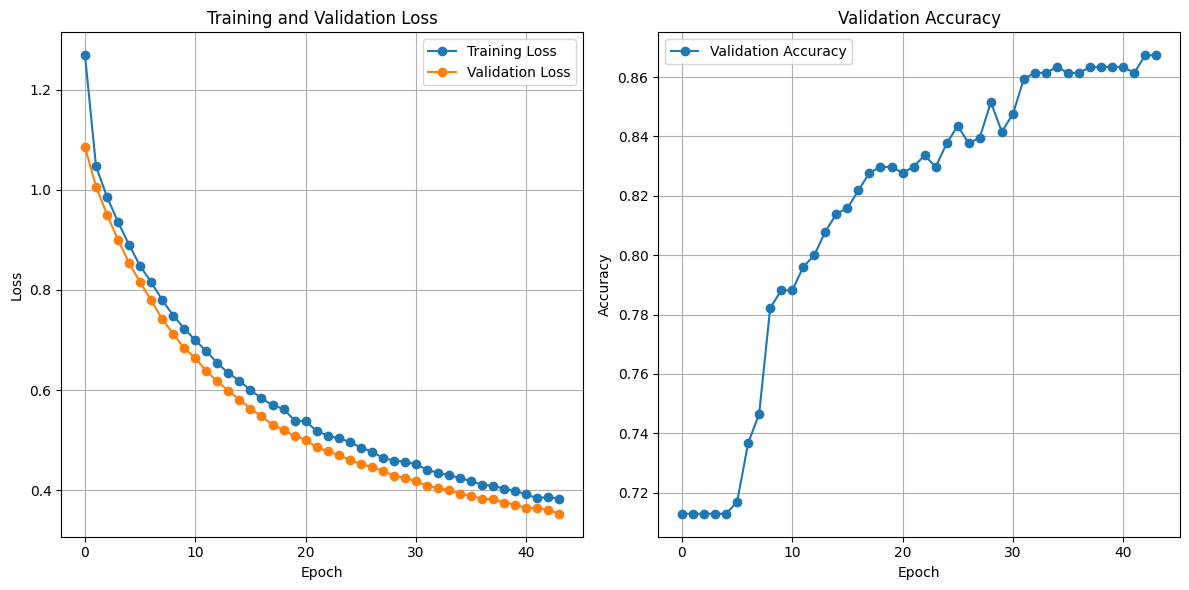

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create directory for plots if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Read the metrics from the logs directory
metrics_path = '/content/drive/My Drive/LUMT_Thesis_Resources/PaSST_training/PaSST_setup3/metrics_PaSST3.csv'
metrics = pd.read_csv(metrics_path)

# Show the first few rows to inspect CSV formatting
print("Initial metrics data:")
print(metrics.head())

# If your CSV contains multiple rows per epoch, group them by epoch.
# Here we take the last logged value per epoch. Adjust as needed.
if metrics['epoch'].duplicated().any():
    metrics = metrics.groupby('epoch', as_index=False).last()
    print("\nMetrics after grouping by epoch (taking last value per epoch):")
    print(metrics.head())
else:
    print("\nNo duplicated epochs found; using CSV directly.")

# Create the figure with subplots
plt.figure(figsize=(12, 6))

# Plot training and validation loss using 'train_loss_epoch'
plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_loss_epoch'], label='Training Loss', marker='o')
plt.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy (if available)
plt.subplot(1, 2, 2)
if 'val_acc' in metrics.columns:
    plt.plot(metrics['epoch'], metrics['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
else:
    print("Warning: 'val_acc' column not found in the CSV.")

plt.tight_layout()

# Save the plot
plot_filename = os.path.join('plots', 'training_metrics.png')
plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
print(f"\nTraining metrics plot saved as {plot_filename}")

# Display the plot within the notebook
plt.show()


I was AFK while the training finished so I lost the finished metrics CSV, this one up to epoch 43/50.

#Inference

1st iteration, use the 2nd one for more advanced metrics


In [ ]:
# Import required libraries
import torch
import numpy as np
from torch.utils.data import DataLoader
import pytorch_lightning as pl

# Define paths
base_path = '/content/drive/My Drive/LUMT_Thesis_Resources'
balanced_metadata_path = '/content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv'

# Create test dataset
test_dataset = GrooveDataset(
    base_path=base_path,
    metadata_path=balanced_metadata_path,
    split='test'
)

# Get number of classes from test dataset
num_classes = len(test_dataset.classes)

# Load the model with the correct number of classes
best_model_path = '/content/drive/My Drive/LUMT_Thesis_Resources/PaSST_training/PaSST_setup3/passt-gmd-epoch=45-val_acc=0.88.ckpt'
model = PaSSTModel.load_from_checkpoint(
    best_model_path,
    num_classes=num_classes
)
model.eval()  # Set to evaluation mode

# Create test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

# Create trainer for testing
trainer = pl.Trainer(
    accelerator='gpu'if torch.cuda.is_available() else 'cpu', # added this as gpu not nessecarily needed for inference
    devices=1,
    logger=False  # We don't need logging for testing
)

# Run inference and collect predictions
test_results = trainer.predict(model, dataloaders=test_loader)

# Combine all predictions and targets
all_preds = []
all_targets = []
for batch in test_results:
    if batch is not None:  # Add error handling
        all_preds.extend(batch['preds'].cpu().numpy())
        all_targets.extend(batch['targets'].cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Print some basic statistics
print(f"\nTotal predictions: {len(all_preds)}")
print(f"Unique predicted classes: {np.unique(all_preds)}")
print(f"Unique true classes: {np.unique(all_targets)}")


Initializing test dataset...
Base path: /content/drive/My Drive/LUMT_Thesis_Resources
Metadata path: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv
Found 515 samples in metadata for test split
After filtering for max_samples: 515 samples
Found 515 valid audio files
Found 9 unique classes

Class distribution for test split:
funk_rock: 5 samples (1.0%)
punk: 28 samples (5.4%)
rock: 354 samples (68.7%)
rock_folk: 11 samples (2.1%)
rock_halftime: 28 samples (5.4%)
rock_indie: 6 samples (1.2%)
rock_prog: 29 samples (5.6%)
rock_rockabilly: 26 samples (5.0%)
rock_shuffle: 28 samples (5.4%)

Initializing PaSST model with 9 classes...
Loading base model...


 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1):

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

Predicting: |          | 0/? [00:00<?, ?it/s]

Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_035.wav
Loading audio file: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_audio_train/drummer1_session2_90_039.wav


/usr/local/lib/python3.11/dist-packages/torch/functional.py:709: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


x torch.Size([16, 1, 128, 1000])
self.norm(x) torch.Size([16, 768, 12, 99])
 patch_embed :  torch.Size([16, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([16, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([16, 1, 768])
 self.dist_token.shape torch.Size([16, 1, 768])
 final sequence x torch.Size([16, 1190, 768])
 after 12 atten blocks x torch.Size([16, 1190, 768])
forward_features torch.Size([16, 768])
head torch.Size([16, 9])


INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

#Confusion Matrix and Evaluation metrics

1st iteration, use the 2nd one for more advanced metrics

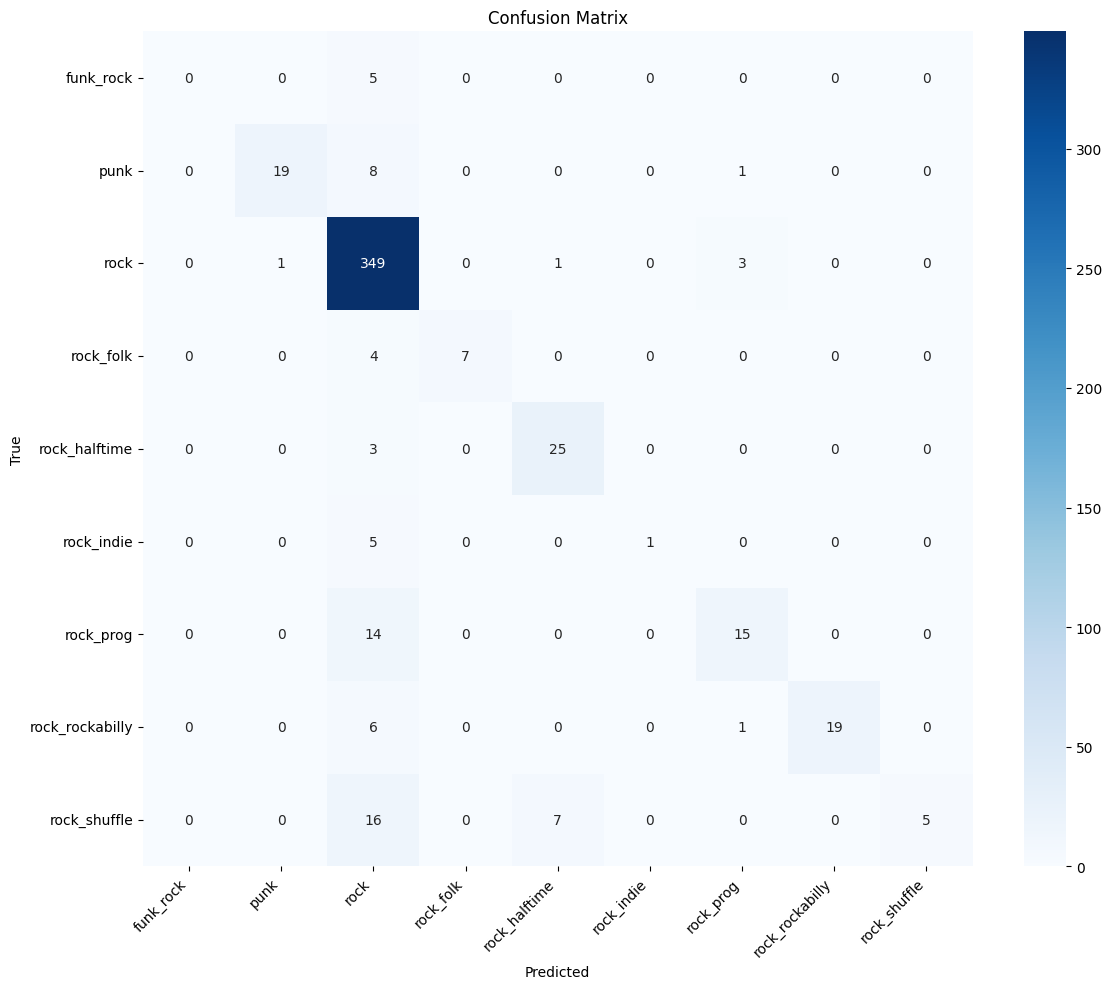


Classification Report:
                 precision    recall  f1-score   support

      funk_rock       0.00      0.00      0.00         5
           punk       0.95      0.68      0.79        28
           rock       0.85      0.99      0.91       354
      rock_folk       1.00      0.64      0.78        11
  rock_halftime       0.76      0.89      0.82        28
     rock_indie       1.00      0.17      0.29         6
      rock_prog       0.75      0.52      0.61        29
rock_rockabilly       1.00      0.73      0.84        26
   rock_shuffle       1.00      0.18      0.30        28

       accuracy                           0.85       515
      macro avg       0.81      0.53      0.59       515
   weighted avg       0.86      0.85      0.83       515


Overall Accuracy: 85.44%

Per-class Accuracy:
funk_rock: 0.00%
punk: 67.86%
rock: 98.59%
rock_folk: 63.64%
rock_halftime: 89.29%
rock_indie: 16.67%
rock_prog: 51.72%
rock_rockabilly: 73.08%
rock_shuffle: 17.86%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Create confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Get class names from test_dataset
class_names = test_dataset.classes

# Create figure with larger size
plt.figure(figsize=(12, 10))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

# Calculate and print overall accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Print per-class accuracy
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i,i] / np.sum(cm[i,:])
    print(f"{class_name}: {class_accuracy:.2%}")

#Updated Inference


In [ ]:
# Import required libraries
import torch
import numpy as np
from torch.utils.data import DataLoader
import pytorch_lightning as pl

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths
base_path = '/content/drive/My Drive/LUMT_Thesis_Resources'
balanced_metadata_path = '/content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv'

# Create test dataset
test_dataset = GrooveDataset(
    base_path=base_path,
    metadata_path=balanced_metadata_path,
    split='test'
)

# Get number of classes from test dataset
num_classes = len(test_dataset.classes)

# Load the model with the correct number of classes
best_model_path = '/content/drive/My Drive/LUMT_Thesis_Resources/PaSST_training/PaSST_setup3/passt-gmd-epoch=45-val_acc=0.88.ckpt'
model = PaSSTModel.load_from_checkpoint(
    best_model_path,
    num_classes=num_classes
)
model.to(device)  # Move model to device
model.eval()  # Set to evaluation mode

# Create test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

# Create trainer for testing
trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False  # We don't need logging for testing
)

# Run inference and collect predictions and probabilities
all_preds = []
all_targets = []
all_probs = []

for batch in test_loader:
    with torch.no_grad():
        # Move batch to GPU
        audio, targets = batch[0].to(device), batch[1]

        # Get model outputs
        outputs = model(audio)

        # Get probabilities using softmax
        probs = torch.softmax(outputs, dim=1)

        # Get predictions
        preds = torch.argmax(outputs, dim=1)

        # Store results
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_probs = np.array(all_probs)

print(f"Total predictions: {len(all_preds)}")
print(f"Unique predicted classes: {np.unique(all_preds)}")
print(f"Unique true classes: {np.unique(all_targets)}")

Using device: cpu

Initializing test dataset...
Base path: /content/drive/My Drive/LUMT_Thesis_Resources
Metadata path: /content/drive/My Drive/LUMT_Thesis_Resources/groove_2bar_16000hz_segmented_metadata_allrock_punk_v2_modified_split_rev.csv
Found 515 samples in metadata for test split
After filtering for max_samples: 515 samples
Found 515 valid audio files
Found 9 unique classes

Class distribution for test split:
funk_rock: 5 samples (1.0%)
punk: 28 samples (5.4%)
rock: 354 samples (68.7%)
rock_folk: 11 samples (2.1%)
rock_halftime: 28 samples (5.4%)
rock_indie: 6 samples (1.2%)
rock_prog: 29 samples (5.6%)
rock_rockabilly: 26 samples (5.0%)
rock_shuffle: 28 samples (5.4%)

Initializing PaSST model with 9 classes...
Loading base model...


 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Blo

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

/usr/local/lib/python3.11/dist-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


Total predictions: 515
Unique predicted classes: [1 2 3 4 5 6 7 8]
Unique true classes: [0 1 2 3 4 5 6 7 8]


#Evaluation Metrics and Visualization

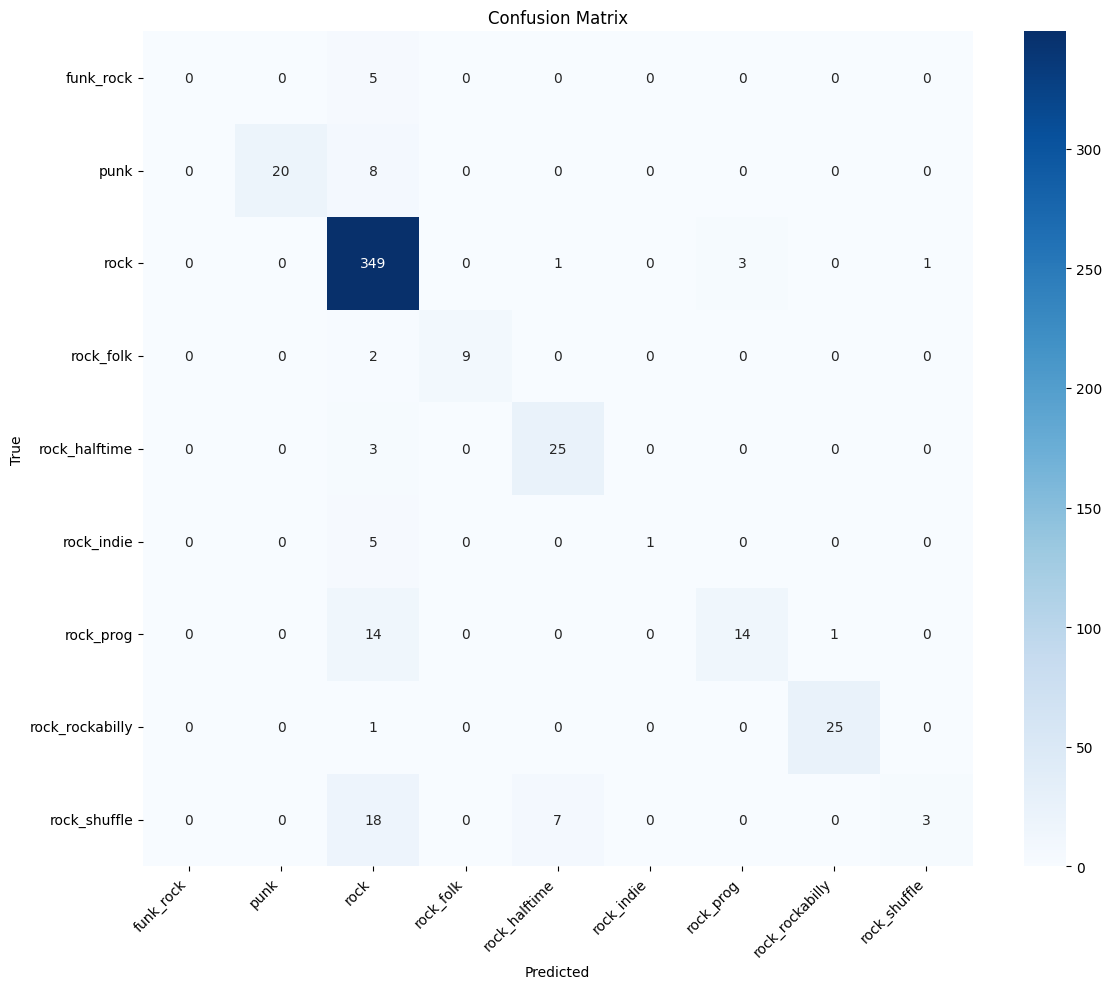


Classification Report:
                 precision    recall  f1-score   support

      funk_rock       0.00      0.00      0.00         5
           punk       1.00      0.71      0.83        28
           rock       0.86      0.99      0.92       354
      rock_folk       1.00      0.82      0.90        11
  rock_halftime       0.76      0.89      0.82        28
     rock_indie       1.00      0.17      0.29         6
      rock_prog       0.82      0.48      0.61        29
rock_rockabilly       0.96      0.96      0.96        26
   rock_shuffle       0.75      0.11      0.19        28

       accuracy                           0.87       515
      macro avg       0.79      0.57      0.61       515
   weighted avg       0.86      0.87      0.84       515


Overall Accuracy: 86.60%

Mean Average Precision (mAP): 0.8243
Area Under Curve (AUC): 0.9790

Per-class Metrics:

funk_rock:
  Precision: 0.00%
  Recall: 0.00%
  F1-score: 0.00%
  mAP: 0.4420
  AUC: 0.9380
  Support: 5

punk:
  Pr

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Create confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Get class names from test_dataset
class_names = test_dataset.classes

# Create figure with larger size
plt.figure(figsize=(12, 10))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print classification report with zero_division parameter
print("\nClassification Report:")
print(classification_report(all_targets, all_preds,
                          target_names=class_names,
                          zero_division=0))

# Calculate and print overall accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Calculate mAP and AUC
# Binarize the labels for mAP and AUC calculation
y_true_bin = label_binarize(all_targets, classes=range(len(class_names)))

# Calculate mAP (mean Average Precision)
mAP = average_precision_score(y_true_bin, all_probs, average='macro')
print(f"\nMean Average Precision (mAP): {mAP:.4f}")

# Calculate AUC
try:
    auc = roc_auc_score(y_true_bin, all_probs, average='macro', multi_class='ovr')
    print(f"Area Under Curve (AUC): {auc:.4f}")
except ValueError as e:
    print(f"Could not calculate AUC: {e}")

# Print per-class metrics
print("\nPer-class Metrics:")
for i, class_name in enumerate(class_names):
    # True positives
    tp = cm[i,i]
    # False positives
    fp = np.sum(cm[:,i]) - tp
    # False negatives
    fn = np.sum(cm[i,:]) - tp

    # Calculate precision, recall, and f1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate class-specific mAP and AUC
    class_mAP = average_precision_score(y_true_bin[:, i], all_probs[:, i])
    try:
        class_auc = roc_auc_score(y_true_bin[:, i], all_probs[:, i])
    except ValueError:
        class_auc = np.nan

    print(f"\n{class_name}:")
    print(f"  Precision: {precision:.2%}")
    print(f"  Recall: {recall:.2%}")
    print(f"  F1-score: {f1:.2%}")
    print(f"  mAP: {class_mAP:.4f}")
    print(f"  AUC: {class_auc:.4f}")
    print(f"  Support: {np.sum(cm[i,:])}")